# Курсовой проект для курса "Python для Data Science"
## Задание:
Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели предсказать цены для квартир из файла test.csv.

## Целевая переменная:
Price

## Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

## Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook  с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price). В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

## Сроки и условия сдачи:
Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

## Примечания:
Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая.
В файлах не должны содержаться индексы из датафрейма.
Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.

# Импорт данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%config IPCompleter.greedy=True
%config InlineBackend.figure_format = 'jpeg'
%matplotlib inline
pd.options.display.max_columns = 100

In [204]:
data = pd.read_csv('train.csv')
data.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524


In [205]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


# One Hot Encoding

Смотрим количество уникальных значений, чтобы мы не разорвались по памяти

In [206]:
print('Ecology_2 unique:', data['Ecology_2'].unique())
print('Ecology_3 unique:', data['Ecology_3'].unique())
print('Shops_2 unique:', data['Shops_2'].unique())

Ecology_2 unique: ['B' 'A']
Ecology_3 unique: ['B' 'A']
Shops_2 unique: ['B' 'A']


In [207]:
def one_hot_encoder(adata):
    adata = pd.get_dummies(adata, columns=['Ecology_2', 'Ecology_3', 'Shops_2'])
    adata.drop(columns=['Ecology_2_A', 'Ecology_3_A', 'Shops_2_A'], inplace=True)
    adata.rename(columns={'Ecology_2_B': 'Ecology_2', 'Ecology_3_B': 'Ecology_3', 'Shops_2_B': 'Shops_2'}, inplace=True)
    return adata


data = one_hot_encoder(data.copy())
data.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2,Ecology_3,Shops_2
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,NaN,0,11,184966.930730,1,1,1
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16,300009.450063,1,1,1
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3,220925.908524,1,1,1


# Модели

Обучим на идеальном подмножестве выборки данных модели, которые исправят выбросы в данных

In [208]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


def model_fit(x_train, x_test, y_train, y_test):
    clf = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                       param_grid=[{'n_estimators': [100], 'max_depth': [3, 5, 9, 15, 27]}],
                       cv=5)
    clf.fit(x_train, y_train)
    print('r2:', r2_score(y_test, clf.predict(x_test)))
    return clf


def show_model(clf_model):
    print('Лучшие параметры модели:', clf_model.best_params_)
    for mean, std, params in zip(clf_model.cv_results_['mean_test_score'], clf_model.cv_results_['std_test_score'], clf_model.cv_results_['params']):
        print("%0.4f (±%0.4f) for %r" % (mean, std * 2, params))

# Подготавливаем неправильно вбитые данные
## Swap bigger 'LifeSquare' with 'Square'

In [209]:
def swap_lifesquare_with_square(adata):
    tmp_filter_col = lambda df: (df['LifeSquare'].notna()) & (df['LifeSquare'] > df['Square'])
    adata['tmp_filter_col'] = tmp_filter_col(adata)
    print('Before LifeSquare⇔Square swap: ', adata.loc[tmp_filter_col, 'Id'].count())
    adata.loc[adata['tmp_filter_col'], 'LifeSquare'], adata.loc[adata['tmp_filter_col'], 'Square'] = adata.loc[adata['tmp_filter_col'], 'Square'], adata.loc[adata['tmp_filter_col'], 'LifeSquare']
    print('After LifeSquare⇔Square swap: ', adata.loc[tmp_filter_col, 'Id'].count())
    adata.drop(columns=['tmp_filter_col'], inplace=True)
    return adata
data = swap_lifesquare_with_square(data.copy())

Before LifeSquare⇔Square swap:  482
After LifeSquare⇔Square swap:  0


## Swap bigger 'Floor' with 'HouseFloor'

In [210]:
def swap_floor_with_housefloor(adata):
    tmp_filter_col = lambda df: (df['HouseFloor'] > 0) & (df['Floor'] > df['HouseFloor'])
    adata['tmp_filter_col'] = tmp_filter_col(adata)
    print('Before Floor⇔HouseFloor swap: ', adata.loc[tmp_filter_col, 'Id'].count())
    adata.loc[adata['tmp_filter_col'], 'Floor'], adata.loc[adata['tmp_filter_col'], 'HouseFloor'] = adata.loc[adata['tmp_filter_col'], 'HouseFloor'], adata.loc[adata['tmp_filter_col'], 'Floor']
    print('After Floor⇔HouseFloor swap: ', adata.loc[tmp_filter_col, 'Id'].count())
    adata.drop(columns=['tmp_filter_col'], inplace=True)
    return adata
data = swap_floor_with_housefloor(data.copy())

Before Floor⇔HouseFloor swap:  1556
After Floor⇔HouseFloor swap:  0


In [9]:
data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2,Ecology_3,Shops_2
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,57.223484,36.048753,6.273300,7.943200,13.192900,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399,0.990300,0.972500,0.917500
std,4859.01902,43.587592,0.839512,77.309420,19.372398,28.560917,5.228127,6.372139,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865,0.098015,0.163543,0.275139
min,0.00000,0.000000,0.000000,2.377248,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.866858,22.765174,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942,1.000000,1.000000,1.000000
50%,8394.50000,36.000000,2.000000,52.633651,32.760108,6.000000,7.000000,14.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,1.000000,1.000000,1.000000
75%,12592.50000,75.000000,2.000000,66.004634,45.029599,9.000000,11.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171,1.000000,1.000000,1.000000
max,16798.00000,209.000000,19.000000,7480.592129,638.163193,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000


# Выбросы HouseYear

In [211]:
def fix_houseyear(adata, hy_median):
    invalid_hy_filter = lambda df: ((df['HouseYear'] < 1900) | (df['HouseYear'] > 2030))
    adata.loc[lambda df: invalid_hy_filter(df), 'HouseYear'] = hy_median
    return adata

In [212]:
hy_median = data['HouseYear'].median()
data = fix_houseyear(data.copy(), hy_median)
data.loc[:, ['HouseYear']].describe()

,HouseYear
count,10000.000000
mean,1984.863800
std,18.409979
min,1910.000000
25%,1974.000000
50%,1977.000000
75%,2001.000000
max,2020.000000


# Выбросы HouseFloor

In [213]:
def fix_housefloor(adata, hf_basedon_year, hf_median):
    invalid_hf_filter = lambda df: ((df['HouseFloor'] < 1) | (df['HouseFloor'] > 50))
    fixed_hf = adata.loc[lambda df: invalid_hf_filter(df), 'HouseYear'].map(lambda yr: hf_basedon_year.get(yr, default=hf_median))
    adata.loc[lambda df: invalid_hf_filter(df), 'HouseFloor'] = fixed_hf
    return adata

In [214]:
hf_basedon_year = data.groupby('HouseYear')['HouseFloor'].median()
hf_median = data['HouseYear'].median()
data = fix_housefloor(data.copy(), hf_basedon_year,  hf_median)
data.loc[:, ['HouseFloor']].describe()

,HouseFloor
count,10000.000000
mean,13.623800
std,5.794811
min,1.000000
25%,9.000000
50%,14.000000
75%,17.000000
max,48.000000


# Отсутствующие значения Healthcare_1

In [215]:
healthcare_corr = data.loc[lambda df: df['Healthcare_1'].notnull(), :].corr().loc[lambda df: (np.abs(df['Healthcare_1']) > 0.1) & (np.abs(df['Healthcare_1']) < 1), ['Healthcare_1']]
healthcare_corr

,Healthcare_1
DistrictId,0.304335
Floor,-0.112202
HouseFloor,-0.191400
HouseYear,-0.205125
Social_3,0.133877
Helthcare_2,0.203177
Price,0.138755
Ecology_3,-0.114715


In [18]:
x_train, x_test, y_train, y_test = train_test_split(
    data.loc[lambda df: df['Healthcare_1'].notnull(), ['DistrictId', 'Floor', 'HouseFloor', 'HouseYear', 'Social_3', 'Helthcare_2', 'Ecology_3']],
    data.loc[lambda df: df['Healthcare_1'].notnull(), 'Healthcare_1'],
    test_size=0.25,
    random_state=42
)
clf_healthcare = model_fit(x_train, x_test, y_train, y_test)
show_model(clf_healthcare)

r2: 0.9858626888672526
Лучшие параметры модели: {'max_depth': 27, 'n_estimators': 100}
0.3687 (±0.0399) for {'max_depth': 3, 'n_estimators': 100}
0.6467 (±0.0514) for {'max_depth': 5, 'n_estimators': 100}
0.9303 (±0.0332) for {'max_depth': 9, 'n_estimators': 100}
0.9689 (±0.0225) for {'max_depth': 15, 'n_estimators': 100}
0.9692 (±0.0224) for {'max_depth': 27, 'n_estimators': 100}


In [216]:
def fix_healthcare1(adata, model):
    hc1_filter = lambda df: df['Healthcare_1'].isnull()
    features = adata.loc[lambda df: hc1_filter(df), ['DistrictId', 'Floor', 'HouseFloor', 'HouseYear', 'Social_3', 'Helthcare_2', 'Ecology_3']]
    adata.loc[lambda df: hc1_filter(df), 'Healthcare_1'] = model.predict(features)
    return adata


data = fix_healthcare1(data.copy(), clf_healthcare)

# Выбросы Rooms

In [217]:
data['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Отфильтровано: 17 из 10000


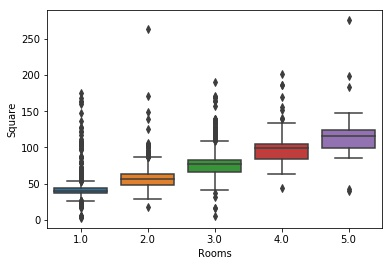

In [218]:
rooms_filter = lambda df: (df['Rooms'] >= 1) & (df['Rooms'] <= 5) & (df['Square'] <= 400)
print('Отфильтровано:', len(data.loc[lambda df: ~rooms_filter(df), 'Rooms']), 'из', len(data['Rooms']))
sns.boxplot(data.loc[lambda df: rooms_filter(df), 'Rooms'], data.loc[lambda df: rooms_filter(df), 'Square'])

In [219]:
square_quantiles = data.loc[lambda df: rooms_filter(df), :].groupby('Rooms')[['Square']].quantile(q=[0.25, 0.5, 0.75], interpolation='nearest')
square_quantiles

Square
Rooms                 
1.0   0.25   36.730798
      0.50   40.504282
      0.75   43.656886
2.0   0.25   47.885352
      0.50   55.896394
      0.75   63.456181
3.0   0.25   66.033045
      0.50   77.466387
      0.75   83.268318
4.0   0.25   83.833387
      0.50   98.686703
      0.75  104.769022
5.0   0.25   95.617533
      0.50  114.313752
      0.75  124.933289

In [220]:
def fix_rooms(adata):
    adata.loc[lambda df: df['Square'] < 45, 'Rooms'] = 1.0
    adata.loc[lambda df: (df['Square'] >= 45) & (df['Square'] < 65), 'Rooms'] = 2.0
    adata.loc[lambda df: (df['Square'] >= 65) & (df['Square'] < 85), 'Rooms'] = 3.0
    adata.loc[lambda df: (df['Square'] >= 85) & (df['Square'] < 100), 'Rooms'] = 4.0
    adata.loc[lambda df: df['Square'] > 100, 'Rooms'] = 5.0
    return adata


fix_rooms(data.copy()).corr().where(lambda v: (np.abs(v) > 0.1) & (np.abs(v) < 1))[['Rooms']].dropna().sort_values('Rooms', ascending=False)

,Rooms
LifeSquare,0.685835
Price,0.564593
Square,0.268729
HouseYear,0.155315
HouseFloor,0.120555


In [221]:
data = fix_rooms(data.copy())

# Выбросы Square

In [222]:
square_filter = lambda df: (df['Square'] > 20) & (df['Square'] < 220)
print('Отфильтровано:', len(data.loc[lambda df: ~square_filter(df), 'Square']), 'из', len(data['Square']))
data.loc[lambda df: square_filter(df), :].corr().where(lambda df: (df > 0.1) & (df < 1))[['Square']].dropna().sort_values('Square', ascending=False)

Отфильтровано: 24 из 10000


,Square
Rooms,0.938814
LifeSquare,0.774484
Price,0.580907
HouseYear,0.191489
HouseFloor,0.150899


In [77]:
x_train, x_test, y_train, y_test = train_test_split(
    data.loc[lambda df: square_filter(df), ['Rooms', 'HouseFloor', 'HouseYear', 'Floor', 'DistrictId']],
    data.loc[lambda df: square_filter(df), 'Square'],
    test_size=0.25,
    random_state=42
)
clf_square = model_fit(x_train, x_test, y_train, y_test)
show_model(clf_square)

r2: 0.906499402360459
Лучшие параметры модели: {'max_depth': 5, 'n_estimators': 100}
0.9000 (±0.0140) for {'max_depth': 3, 'n_estimators': 100}
0.9029 (±0.0165) for {'max_depth': 5, 'n_estimators': 100}
0.9027 (±0.0161) for {'max_depth': 9, 'n_estimators': 100}
0.8969 (±0.0146) for {'max_depth': 15, 'n_estimators': 100}
0.8930 (±0.0143) for {'max_depth': 27, 'n_estimators': 100}


In [223]:
def fix_square(adata, model):
    features = adata.loc[lambda df: ~square_filter(df), ['Rooms', 'HouseFloor', 'HouseYear', 'Floor', 'DistrictId']]
    adata.loc[lambda df: ~square_filter(df), 'Square'] = model.predict(features)
    return adata


data = fix_square(data.copy(), clf_square)
data.corr().where(lambda df: (df > 0.1) & (df < 1))[['Square']].dropna().sort_values('Square', ascending=False)

,Square
Rooms,0.939293
LifeSquare,0.724070
Price,0.577750
HouseYear,0.193246
HouseFloor,0.151755


# Отсутствующие значения LifeSquare

In [224]:
lifesquare_filter = lambda df: (
    (df['LifeSquare'].notna()) & 
    (df['LifeSquare'] > 20) & 
    (df['LifeSquare'] < 220) & 
    (df['LifeSquare'] < df['Square'] * 0.9) &
    (df['LifeSquare'] > df['Square'] * 0.3)
)
print('Отфильтровано:', len(data.loc[lambda df: ~lifesquare_filter(df), 'LifeSquare']), 'из', len(data['LifeSquare']))
data.loc[lambda df: lifesquare_filter(df), :].corr().where(lambda df: (df > 0.1) & (df < 1))[['LifeSquare']].dropna().sort_values('LifeSquare', ascending=False)

Отфильтровано: 4203 из 10000


,LifeSquare
Square,0.921421
Rooms,0.883492
Price,0.606095
KitchenSquare,0.271837
HouseFloor,0.119942
HouseYear,0.117184


In [225]:
x_train, x_test, y_train, y_test = train_test_split(
    data.loc[lambda df: lifesquare_filter(df), ['Square', 'Rooms', 'HouseYear', 'HouseFloor']],
    data.loc[lambda df: lifesquare_filter(df), 'LifeSquare'],
    test_size=0.25,
    random_state=42
)
clf_lifesquare = model_fit(x_train, x_test, y_train, y_test)
show_model(clf_lifesquare)

r2: 0.8693254699441086
Лучшие параметры модели: {'max_depth': 9, 'n_estimators': 100}
0.8487 (±0.0179) for {'max_depth': 3, 'n_estimators': 100}
0.8909 (±0.0056) for {'max_depth': 5, 'n_estimators': 100}
0.8935 (±0.0089) for {'max_depth': 9, 'n_estimators': 100}
0.8894 (±0.0082) for {'max_depth': 15, 'n_estimators': 100}
0.8873 (±0.0088) for {'max_depth': 27, 'n_estimators': 100}


In [226]:
def fix_lifesquare(adata, model):
    features = adata.loc[lambda df: ~lifesquare_filter(df), ['Square', 'Rooms', 'HouseYear', 'HouseFloor']]
    adata.loc[lambda df: ~lifesquare_filter(df), 'LifeSquare'] = model.predict(features)
    return adata


data = fix_lifesquare(data.copy(), clf_lifesquare)
data.corr().where(lambda df: (df > 0.1) & (df < 1))[['LifeSquare']].dropna().sort_values('LifeSquare', ascending=False)

,LifeSquare
Square,0.941411
Rooms,0.901423
Price,0.575204


# Выбросы KitchenSquare

Отфильтровано: 3313 из 10000


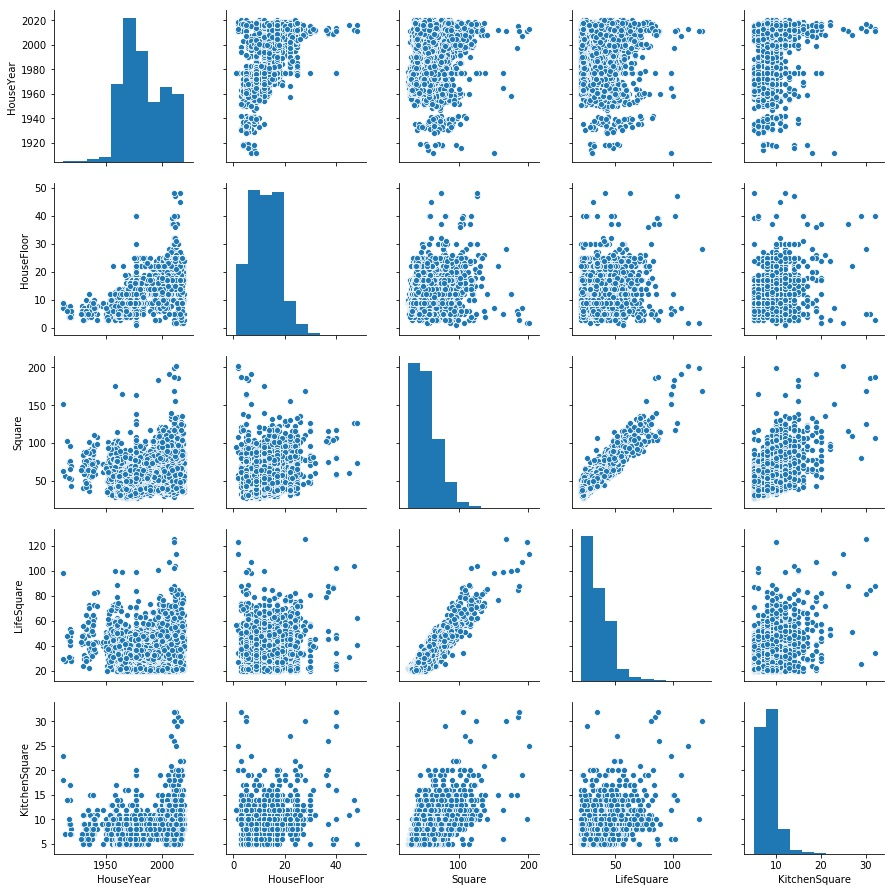

In [253]:
ks_filter = lambda df: (df['KitchenSquare'] >= 5) & (df['KitchenSquare'] <= 40) & (df['KitchenSquare'] < df['Square'] - df['LifeSquare'])
print('Отфильтровано:', len(data.loc[lambda df: ~ks_filter(df), 'KitchenSquare']), 'из', len(data['KitchenSquare']))
sns.pairplot(data.loc[lambda df: ks_filter(df), ['HouseYear', 'HouseFloor', 'Square', 'LifeSquare', 'KitchenSquare']])

In [254]:
data.loc[lambda df: ks_filter(df), :].corr().where(lambda v: (np.abs(v) > 0.1) & (np.abs(v) < 1))[['KitchenSquare']].dropna().sort_values('KitchenSquare', ascending=False)

,KitchenSquare
HouseYear,0.568134
HouseFloor,0.548830
Square,0.543908
Rooms,0.462148
LifeSquare,0.349083
Floor,0.313337
Price,0.302425
Healthcare_1,-0.102762
Social_1,-0.122539


In [255]:
x_train, x_test, y_train, y_test = train_test_split(
    data.loc[lambda df: ks_filter(df), ['HouseYear', 'HouseFloor', 'Square', 'Rooms', 'LifeSquare', 'Floor', 'DistrictId', 'Healthcare_1', 'Helthcare_2', 'Social_1']],
    data.loc[lambda df: ks_filter(df), 'KitchenSquare'],
    test_size=0.25,
    random_state=42
)
clf_kitchen = model_fit(x_train, x_test, y_train, y_test)
show_model(clf_kitchen)

r2: 0.6854377495581627
Лучшие параметры модели: {'max_depth': 15, 'n_estimators': 100}
0.5341 (±0.0595) for {'max_depth': 3, 'n_estimators': 100}
0.6224 (±0.0682) for {'max_depth': 5, 'n_estimators': 100}
0.6690 (±0.0670) for {'max_depth': 9, 'n_estimators': 100}
0.6744 (±0.0576) for {'max_depth': 15, 'n_estimators': 100}
0.6734 (±0.0615) for {'max_depth': 27, 'n_estimators': 100}


In [256]:
def fix_kitchensquare(adata, model):
    features = adata.loc[lambda df: ~ks_filter(df), ['HouseYear', 'HouseFloor', 'Square', 'Rooms', 'LifeSquare', 'Floor', 'DistrictId', 'Healthcare_1', 'Helthcare_2', 'Social_1']]
    adata.loc[lambda df: ~ks_filter(df), 'KitchenSquare'] = model.predict(features)
    return adata


fix_kitchensquare(data.copy(), clf_kitchen).corr().where(lambda df: (df > 0.1) & (df < 1))[['KitchenSquare']].dropna().sort_values('KitchenSquare', ascending=False)

,KitchenSquare
Square,0.568745
Rooms,0.501156
HouseYear,0.469320
HouseFloor,0.446408
LifeSquare,0.403923
Floor,0.217232
Price,0.184517


In [278]:
data = fix_kitchensquare(data.copy(), clf_kitchen)

# Корелляция

In [279]:
perceptible_corr = data.drop(columns='Id').corr().where(lambda v: (np.abs(v) > 0.1) & (np.abs(v) < 1))
perceptible_corr

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2,Ecology_3,Shops_2
DistrictId,NaN,NaN,NaN,NaN,-0.221993,NaN,-0.219881,-0.201194,NaN,0.246463,0.167479,0.136095,0.325802,0.306147,0.174214,0.265100,NaN,NaN,NaN
Rooms,NaN,NaN,0.939293,0.901423,0.501156,NaN,0.120555,0.155315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.564593,NaN,NaN,NaN
Square,NaN,0.939293,NaN,0.941411,0.568745,NaN,0.151755,0.193246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.577750,NaN,NaN,NaN
LifeSquare,NaN,0.901423,0.941411,NaN,0.403923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.575204,NaN,NaN,NaN
KitchenSquare,-0.221993,0.501156,0.568745,0.403923,NaN,0.217232,0.446408,0.469320,-0.123736,-0.319694,-0.246818,NaN,-0.161663,-0.218247,-0.103017,0.184517,NaN,NaN,-0.131578
Floor,NaN,NaN,NaN,NaN,0.217232,NaN,0.598678,0.258989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.113605,NaN,NaN,NaN
HouseFloor,-0.219881,0.120555,0.151755,NaN,0.446408,0.598678,NaN,0.461408,NaN,-0.106483,NaN,NaN,-0.159567,-0.140463,NaN,0.107305,NaN,NaN,NaN
HouseYear,-0.201194,0.155315,0.193246,NaN,0.469320,0.258989,0.461408,NaN,NaN,NaN,NaN,NaN,-0.193124,-0.116430,NaN,NaN,NaN,NaN,NaN
Ecology_1,NaN,NaN,NaN,NaN,-0.123736,NaN,NaN,NaN,NaN,NaN,NaN,-0.124068,NaN,NaN,NaN,NaN,-0.110725,-0.223197,NaN
Social_1,0.246463,NaN,NaN,NaN,-0.319694,NaN,-0.106483,NaN,NaN,NaN,0.955988,NaN,0.158859,0.524593,0.526272,0.263286,NaN,NaN,0.144644


Колонки, влияющие на цену

In [280]:
price_corr_columns = perceptible_corr[['Price']].dropna().sort_values('Price', ascending=False)
print(price_corr_columns.index.values)
price_corr_columns

['Square' 'LifeSquare' 'Rooms' 'DistrictId' 'Social_1' 'Helthcare_2'
 'Social_2' 'KitchenSquare' 'Healthcare_1' 'Shops_1' 'Floor' 'HouseFloor']


,Price
Square,0.577750
LifeSquare,0.575204
Rooms,0.564593
DistrictId,0.265100
Social_1,0.263286
Helthcare_2,0.253090
Social_2,0.239226
KitchenSquare,0.184517
Healthcare_1,0.181614
Shops_1,0.180876


# Собираем итоговый датафрейм

In [271]:
def preprocessData(df, houseyear_median, housefloor_basedon_year, housefloor_median, healthcare_model, square_model, lifesquare_model, kitchensquare_model):
    df = one_hot_encoder(df)  # 'Ecology_2', 'Ecology_3', 'Shops_2'
    df = swap_lifesquare_with_square(df.copy())  # подготавливаем 'LifeSquare', 'Square'
    df = swap_floor_with_housefloor(df.copy())  # подготавливаем 'Floor', 'HouseFloor'
    df = fix_houseyear(df.copy(), houseyear_median)  # исправляем HouseYear
    df = fix_housefloor(df.copy(), housefloor_basedon_year, housefloor_median)  # исправляем HouseFloor
    df = fix_healthcare1(df.copy(), healthcare_model)  # исправляем Healthcare_1
    df = fix_rooms(df.copy())  # исправляем Rooms
    df = fix_square(df.copy(), square_model)  # исправляем Square
    df = fix_lifesquare(df.copy(), lifesquare_model)  # заполняем пустые значения LifeSquare
    df = fix_kitchensquare(data.copy(), kitchensquare_model)  # исправляем KitchenSquare
    return df

data_final = preprocessData(pd.read_csv('train.csv'), hy_median, hf_basedon_year, hf_median, clf_healthcare, clf_square, clf_lifesquare, clf_kitchen)

Before LifeSquare⇔Square swap:  482
After LifeSquare⇔Square swap:  0
Before Floor⇔HouseFloor swap:  1556
After Floor⇔HouseFloor swap:  0


# Масштабируем признаки

In [272]:
from sklearn.preprocessing import StandardScaler
train_columns = data_final.columns.copy().drop(['Id', 'Price'])
print('total features:', len(train_columns))
df_train = data_final.loc[:, train_columns]
df_test = data_final.loc[:, data_final.columns == 'Price']

scaler = StandardScaler()
df_train_scaled = scaler.fit_transform(df_train)
df_train_scaled = pd.DataFrame(df_train_scaled, columns=train_columns)
df_train_scaled.head(3)

total features: 18


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2,Ecology_3,Shops_2
0,-0.353348,-0.012591,-0.439182,-0.387384,-1.101441,-0.180418,-0.797961,-0.861739,-0.250529,0.474169,0.654880,-0.127533,-0.653717,-0.883480,1.408356,0.09897,0.16816,0.299864
1,-0.215687,1.011047,0.491286,0.506121,-0.286209,-0.180418,-0.797961,-0.372849,-0.998053,1.215681,1.237169,-0.295384,-0.895595,-0.213923,2.448700,0.09897,0.16816,0.299864
2,0.059635,-1.036229,-0.598636,-0.408034,-1.302963,0.010865,-0.280230,-0.916060,-0.581588,0.531208,0.600720,-0.337347,-0.908365,-0.213923,-0.256195,0.09897,0.16816,0.299864


# Предсказание
Наблюдаем за изменением главной метрики

In [273]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
x_train, x_test, y_train, y_test = train_test_split(
    df_train_scaled, 
    df_test, 
    test_size=0.25, 
    random_state=42
)

## LinearRegression

In [274]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
print('Начальное значение:', 0.4520388943512419)
r2_score(y_test, y_pred)

Начальное значение: 0.4520388943512419


0.5058922134104271

## DecisionTreeRegressor

In [275]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=42, max_depth=9)
dtr.fit(x_train, y_train)
y_pred = dtr.predict(x_test)
print('Начальное значение:', 0.624564658797478)
r2_score(y_test, y_pred)

Начальное значение: 0.624564658797478


0.6243420857114348

## RandomForestRegressor с обучением на фолдах

In [276]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
clf_final = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42), 
    param_grid=[{'n_estimators': [100],  
                 'max_depth': [17],
                 'max_features': [9]}],
    cv=5
)
clf_final.fit(x_train, y_train)
#  {'max_depth': [9, 15, 17, 19, 27], 'max_features': [9, 15, 21], 'n_estimators': 10}
cell_index = clf_final.cv_results_['params'].index(clf_final.best_params_)
mean = clf_final.cv_results_['mean_test_score'][cell_index]
std = clf_final.cv_results_['std_test_score'][cell_index]
print("%0.4f (±%0.4f) for %r" % (mean, std * 2, clf_final.best_params_))
print('r2', r2_score(y_test, clf_final.predict(x_test)))

0.7340 (±0.0436) for {'max_depth': 17, 'max_features': 9, 'n_estimators': 100}
r2 0.7147490109927677


In [277]:
pd.Series(clf_final.best_estimator_.feature_importances_, index=train_columns).sort_values(ascending=False)

Square           0.273935
LifeSquare       0.136249
Social_2         0.096758
Social_1         0.089121
Rooms            0.068422
Social_3         0.060634
DistrictId       0.049180
Ecology_1        0.041298
Healthcare_1     0.035622
HouseYear        0.033033
HouseFloor       0.029903
KitchenSquare    0.026381
Floor            0.022270
Shops_1          0.020378
Helthcare_2      0.014615
Shops_2          0.001055
Ecology_3        0.000663
Ecology_2        0.000483
dtype: float64